In [1]:
import tensorflow as tf
import numpy as np
import cv2
import glob
import os
import random
import sys
import pathlib
from matplotlib import pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
from load_paper_data import get_data_loader
from sklearn.metrics import confusion_matrix
import seaborn as sns
from tensorflow.python.framework import graph_util
%matplotlib inline

sys.path.append("ocr/src")

from ocr import words, characters
from ocr.tfhelpers import Model

MODEL_LOC = "./ocr/models/char-clas/en/CharClassifier"

O_HEIGHT = 96
O_WIDTH = 256
HEIGHT = 192
WIDTH = 512
CHANNEL = 1

np.random.seed(1)

Loading segmentation models...
INFO:tensorflow:Restoring parameters from /home/jhm9507/research-2019-grading/ocr/src/ocr/../../models/gap-clas/CNN-CG
INFO:tensorflow:Restoring parameters from /home/jhm9507/research-2019-grading/ocr/src/ocr/../../models/gap-clas/RNN/Bi-RNN-new


In [2]:
class readdata:
    def __init__(self,q_num,data_len,train=True):
        if train:
            self.loader = iter(get_data_loader(q_num,data_len))
        else:
            self.loader = iter(get_data_loader(q_num,data_len,False))
        x_src, x_pos, x_neg = next(self.loader)
        self.data = []
        for i in range(data_len):
            self.data.append([x_src[i].squeeze(), x_pos[i].squeeze(), 1.0])
            self.data.append([x_src[i].squeeze(), x_neg[i].squeeze(), 0.0])
        self.index = 0
        
    def next_batch(self,batch_size):
        x_1 = []
        x_2 = []
        y = []
        for i in range(batch_size):
            if self.index > len(self.data)-1:
                self.index = 0
            x_1.append(self.data[self.index][0])
            x_2.append(self.data[self.index][1])
            y.append(self.data[self.index][2])
            self.index += 1
        return x_1, x_2, y

In [3]:
class preprocessor:
    def get_bboxes(self,img):
        img = cv2.resize(img, dsize=(WIDTH, HEIGHT))
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img[:, :, 0][img_gray > 180] = 255
        img[:, :, 0][img_gray <= 180] = 0
        img[:, :, 1][img_gray > 180] = 255
        img[:, :, 1][img_gray <= 180] = 0
        img[:, :, 2][img_gray > 180] = 255
        img[:, :, 2][img_gray <= 180] = 0
        bboxes = words.detection(img)
        return bboxes


    def preprocess(self,empty_img, img):
        bboxes = self.get_bboxes(empty_img)

        img = cv2.resize(img, dsize=(WIDTH, HEIGHT))
        img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        img[img > 180] = 255
        img[img <= 180] = 0

        for bx in bboxes:
            x1, y1, x2, y2 = bx
            img[0:256, 0:x2+5] = 255

        img_rgb = np.zeros((HEIGHT, WIDTH, 3))
        img_rgb[:, :, 0] = img
        img_rgb[:, :, 1] = img
        img_rgb[:, :, 2] = img

        bboxes = words.detection(img_rgb)

        xx1, yy1, xx2, yy2 = np.inf, np.inf, 0, 0
        for bx in bboxes:
            x1, y1, x2, y2 = bx
            if x1 < xx1:
                xx1 = x1
            if y1 < yy1:
                yy1 = y1
            if x2 > xx2:
                xx2 = x2
            if y2 > yy2:
                yy2 = y2

        img = cv2.resize(img[yy1:yy2, xx1:xx2], dsize=(O_WIDTH, O_HEIGHT))
        img = img.astype(np.float32) / 255
        img[img > 0.75] = 1
        img[img <= 0.75] = 0

        return img

In [4]:
class siamcnn:
    def weight_variable(self,shape,name=None):
        initial = tf.random_normal(shape, stddev=0.001)
        return tf.Variable(initial, name=name)
    
    def conv2d(self,x,layer,strides=[1,1,1,1],padding='SAME',name=None):
        assert isinstance(x, tf.Tensor)
        return tf.nn.conv2d(x,self.param[layer+"_w"],strides=strides,padding=padding,name=name)+self.param[layer+"_b"]
    
    def relu(self,x,name=None):
        return tf.nn.relu(x,name=name)
    
    def batch_norm(self,x):
        mean, var = tf.nn.moments(x, axes=[0])
        return tf.contrib.layers.batch_norm(x,center=True,is_training=True)
    
    def fc(self,x,layer,name):
        return tf.add(tf.matmul(tf.reshape(x,shape=[self.batchsize,-1]),self.param[layer+"_w"]),self.param[layer+"_b"],name=name)
    
    def max_pool(self,x,name=None):
        return tf.nn.max_pool(x,ksize=[1,2,2,1],strides=[1,2,2,1],padding="SAME",name=name)
    
    def drop(self,x,name=None):
        return tf.nn.dropout(x,keep_prob=self.dropout_keep_prob,name=name)
    
    def contrastive_loss(self, y,d,batch_size,name=None):
        tmp= y * tf.square(d)
        tmp2 = (1.0-y) * (1.0-tf.square(d))
        return tf.divide(tf.reduce_sum(tmp +tmp2),batch_size*2,name="loss")
    
    def build_cnn(self, X, dropout, scope):
        with tf.variable_scope(scope,reuse=tf.AUTO_REUSE):
            self.conv1_layer = self.relu(self.batch_norm(self.max_pool(self.conv2d(X,"conv1",name="conv1_layer"))))
            self.conv2_layer = self.relu(self.batch_norm(self.max_pool(self.conv2d(self.conv1_layer,"conv2",name="conv2_layer"))))
            self.conv3_layer = self.relu(self.batch_norm(self.max_pool(self.conv2d(self.conv2_layer,"conv3",name="conv3_layer"))))
            self.dropout_layer = self.drop(self.conv3_layer,name="dropout_layer")
            self.output_layer = self.fc(self.dropout_layer,"fc1",name="output_layer")
            return self.output_layer
        
    def __init__(self):
        self.param = {
            "conv1_w": self.weight_variable(shape=[5,5,1,16],name="conv1_w"),
            "conv1_b": tf.Variable(tf.constant(0.1,shape=[16]), name="conv1_b"),
            "conv2_w": self.weight_variable(shape=[5,5,16,32],name="conv2_w"),
            "conv2_b": tf.Variable(tf.constant(0.1,shape=[32]), name="conv2_b"),
            "conv3_w": self.weight_variable(shape=[5,5,32,64],name="conv3_w"),
            "conv3_b": tf.Variable(tf.constant(0.1,shape=[64]), name="conv3_b"),
            "fc1_w": self.weight_variable(shape=[24576,128],name="fc1_w"),
            "fc1_b": tf.Variable(tf.constant(0.1,shape=[128]),name="fc1_b")
        }
        self.input_x1_ = tf.placeholder(dtype=tf.float32,shape=[None,96,256], name="input_x1")
        self.input_x1 = tf.expand_dims(self.input_x1_,3)
        self.input_x2_ = tf.placeholder(dtype=tf.float32,shape=[None,96,256], name="input_x2")
        self.input_x2 = tf.expand_dims(self.input_x2_,3)
        self.input_y = tf.placeholder(dtype=tf.float32,shape=[None],name="input_y")
        self.dropout_keep_prob = tf.placeholder(dtype=tf.float32,shape=(), name="dropout_keep_prob")
        self.batchsize = tf.placeholder(dtype=tf.float32,shape=(), name="input_batchsize")
        with tf.variable_scope("output"):
            self.output_x1 = self.build_cnn(self.input_x1, self.dropout_keep_prob, "cnn")
            self.output_x2 = self.build_cnn(self.input_x2, self.dropout_keep_prob, "cnn")
            self.distance = tf.sqrt(tf.reduce_sum(tf.square(tf.subtract(self.output_x1, self.output_x2)),axis=1,keepdims=True))
            self.distance = tf.div(self.distance, tf.add(tf.sqrt(tf.reduce_sum(tf.square(self.output_x1),1,keepdims=True)),tf.sqrt(tf.reduce_sum(tf.square(self.output_x2),1,keepdims=True))))
            self.distance = tf.reshape(self.distance, [-1,], name="distance")
        with tf.variable_scope("loss"):
            self.loss = self.contrastive_loss(self.input_y,self.distance,self.batchsize)
        self.train_op = tf.train.AdamOptimizer(0.001).minimize(self.loss)
        tf.add_to_collection("training",self.train_op)          

In [61]:
# batch_3 = readdata(q_num="3",data_len=1000)
# batch_4 = readdata(q_num="4",data_len=1000)
# batch_5 = readdata(q_num="5",data_len=2000)
# batch_3_2 = readdata(q_num="3_2",data_len=500)
# batch_4_2 = readdata(q_num="4_2",data_len=500)
# batch_5_2 = readdata(q_num="5_2",data_len=1000)

In [62]:
# tmp_dir = "./tmp"
# if not os.path.exists(tmp_dir):
#     os.makedirs(tmp_dir)
# tmp_path = os.path.join(tmp_dir,"batch_3.npy")
# np.save(tmp_path,batch_3.data)
# tmp_path = os.path.join(tmp_dir,"batch_4.npy")
# np.save(tmp_path,batch_4.data)
# tmp_path = os.path.join(tmp_dir,"batch_5.npy")
# np.save(tmp_path,batch_5.data)
# tmp_path = os.path.join(tmp_dir,"batch_3_2.npy")
# np.save(tmp_path,batch_3_2.data)
# tmp_path = os.path.join(tmp_dir,"batch_4_2.npy")
# np.save(tmp_path,batch_4_2.data)
# tmp_path = os.path.join(tmp_dir,"batch_5_2.npy")
# np.save(tmp_path,batch_5_2.data)

In [6]:
random.seed(1)
threshold = 0.5
cv = 10
batch = readdata(q_num="3",data_len=1)
batch.data = np.load("./tmp/batch_5.npy").tolist() + np.load("./tmp/batch_5_2.npy").tolist()
random.shuffle(batch.data)
batch.index = 0
batchsize = 4
dropout_keep_prob = 0.5
epochs = 2

with tf.Graph().as_default():
    sess = tf.Session()
    print("Session start")
    with sess.as_default():
        siam = siamcnn()
        print("Model initialize")
    train_op = siam.train_op
    print("Operation define")

    #     
    checkpoint_dir = "./ckpt"
    checkpoint_prefix = os.path.join(checkpoint_dir, "model5")
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)

    sess.run(tf.global_variables_initializer())
    
    print("Variables initialize")
    global total_acc
    total_acc = 0

    def train_step(x1_batch, x2_batch, y_batch, iter, n_batchs,val_data=None):
        feed_dict = {
            siam.input_x1_: x1_batch,
            siam.input_x2_: x2_batch,
            siam.input_y: y_batch,
            siam.dropout_keep_prob: dropout_keep_prob,
            siam.batchsize: batchsize
        }
        _, loss, dist = sess.run([train_op, siam.loss, siam.distance],feed_dict=feed_dict)
        if iter % n_batchs == 0:
            print("{}/{} epochs, loss : {}".format((int)(iter/n_batchs),epochs,loss))
            if val_data != None:
                val_acc = validation(val_data)
                if (int)(iter/n_batchs) == epochs:
                    global total_acc
                    total_acc += val_acc

    def validation(val_data):
        threshold = 0.5
        total = 0
        acc = 0
        graph = tf.get_default_graph()
        input_x1 = graph.get_tensor_by_name('input_x1:0')
        input_x2 = graph.get_tensor_by_name('input_x2:0')
        input_batchsize = graph.get_tensor_by_name("input_batchsize:0")
        dropout = graph.get_tensor_by_name("dropout_keep_prob:0")
        output = graph.get_tensor_by_name("output/distance:0")
        for data in val_data:
            x1 = data[0]
            x2 = data[1]
            y = data[2]
            distance = sess.run(output,feed_dict={input_x1:[x1], input_x2:[x2], input_batchsize:1, dropout:1.0})
            total += 1
            if (y == 1.0 and distance <= threshold) or (y == 0.0 and distance > threshold):
                acc += 1
        print("Validation Accuracy : {}".format(acc/total))
        return acc/total


    def cross_val(cv,sess):
        val_len = int(len(batch.data)/cv)
        total_data = batch.data
        for i in range(cv):
            print("Cross validation {}/{}".format(i+1,cv))
            
            batch.data = total_data[:i*val_len] + total_data[(i+1)*val_len:]
            val_data = total_data[i*val_len:(i+1)*val_len]
            
            n_batchs = (int)(len(batch.data) / batchsize)
            for i in range(n_batchs*epochs):
                x1, x2, y = batch.next_batch(batchsize)
                train_step(x1, x2, y, i+1, n_batchs,val_data)
                
            sess.run(tf.global_variables_initializer())
                  
        global total_acc    
        batch.data = total_data
        print("Average Accuracy : {}".format(total_acc/cv))
            
    def train(sess):
        print("Train start")
        n_batchs = (int)(len(batch.data) / batchsize)
        for i in range(n_batchs*epochs):
            x1, x2, y = batch.next_batch(batchsize)
            train_step(x1, x2, y, i+1, n_batchs)
        saver = tf.train.Saver()    
        saver.save(sess,checkpoint_prefix)
        
#     cross_val(10,sess)
    train(sess)

Session start
Model initialize
Operation define
Variables initialize
Train start
1/2 epochs, loss : 0.003463277593255043
2/2 epochs, loss : 0.0013569475850090384


In [7]:
pre = preprocessor()
images_o = [cv2.imread(file) for file in glob.glob("./data/paper_1_5/train/o/*.png")]
images_o_2 = [cv2.imread(file) for file in glob.glob("./data/paper_1_5_2/train/o/*.png")]

image_empty = [cv2.imread(file) for file in glob.glob("./data/paper_1_5/empty/*.png")]
image_empty = image_empty[0]
for i in range(len(images_o)):
    images_o[i] = pre.preprocess(image_empty,images_o[i])
for i in range(len(images_o_2)):
    images_o_2[i] = pre.preprocess(image_empty,images_o_2[i])
    
images_test_o = [cv2.imread(file) for file in glob.glob("./data/paper_1_5/test/o/*.png")] + [cv2.imread(file) for file in glob.glob("./data/paper_1_5_2/test/o/*.png")]
images_test_x = [cv2.imread(file) for file in glob.glob("./data/paper_1_5/test/x/*.png")] + [cv2.imread(file) for file in glob.glob("./data/paper_1_5_2/test/x/*.png")]
for i in range(len(images_test_o)):
    images_test_o[i] = pre.preprocess(image_empty,images_test_o[i])
for i in range(len(images_test_x)):
    images_test_x[i] = pre.preprocess(image_empty,images_test_x[i])

Session start
Graph restore
INFO:tensorflow:Restoring parameters from ./ckpt/model5
Parameter restore


/home/jhm9507/miniconda3/envs/jhm/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


0.9107142857142857


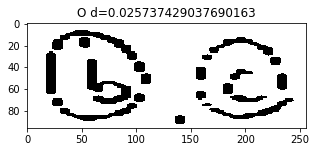

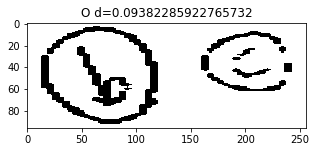

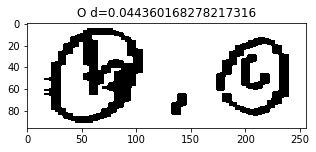

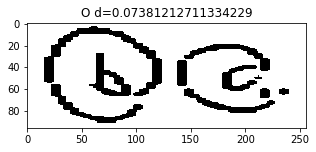

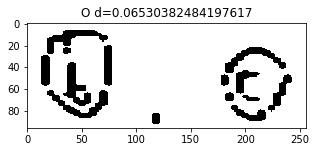

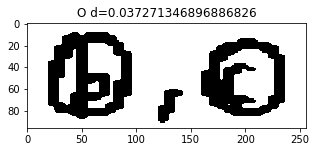

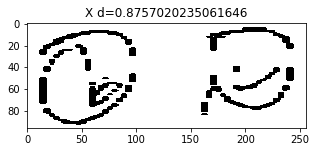

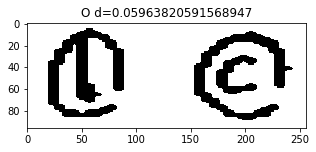

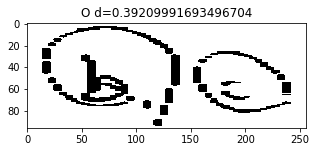

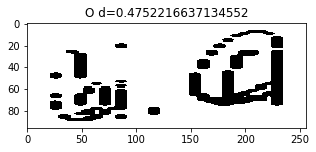

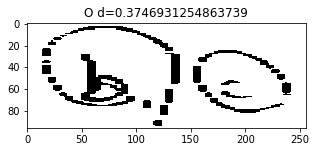

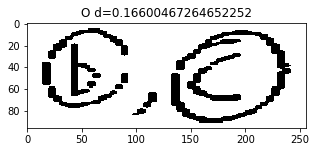

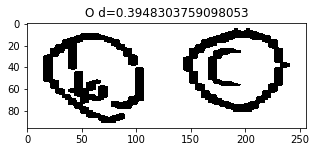

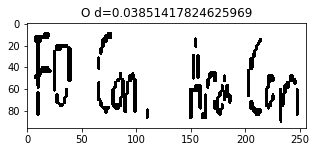

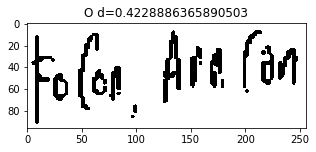

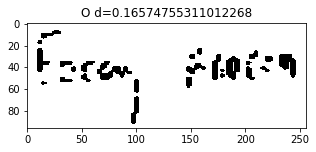

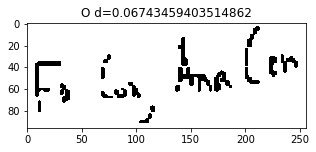

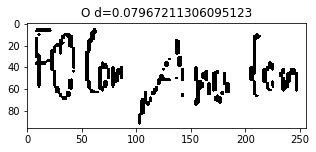

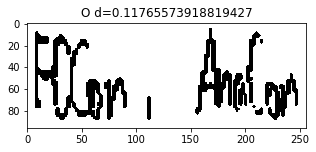

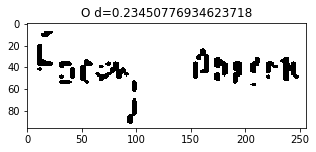

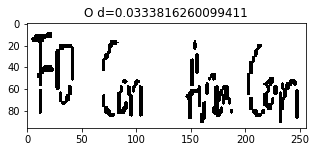

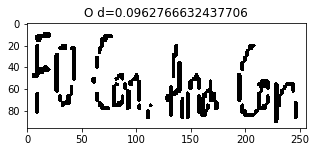

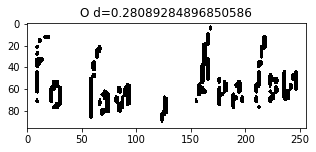

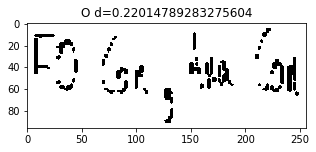

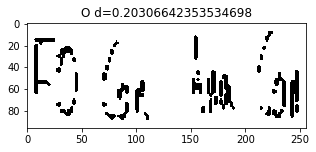

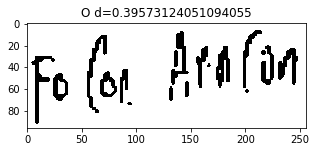

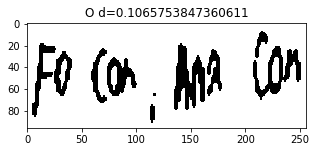

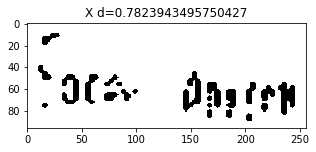

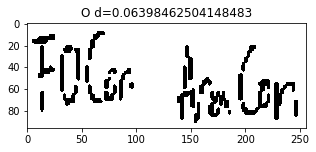

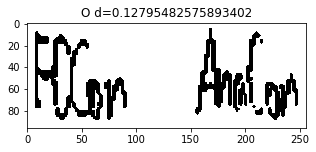

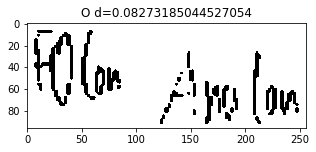

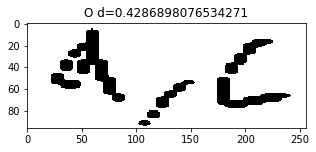

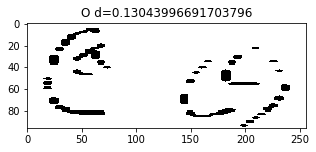

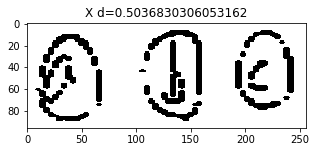

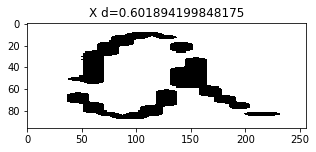

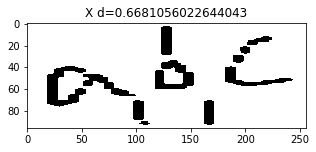

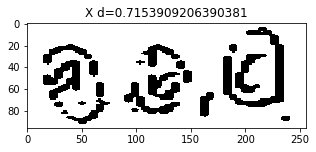

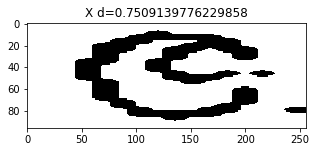

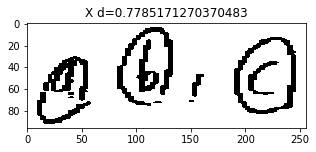

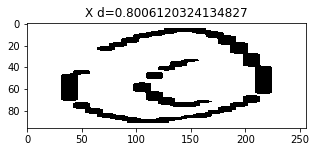

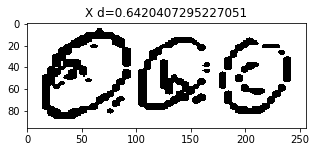

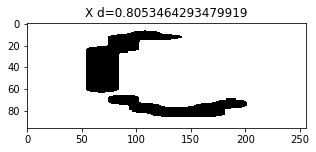

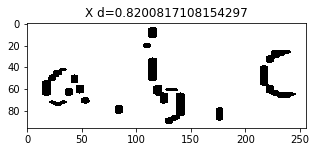

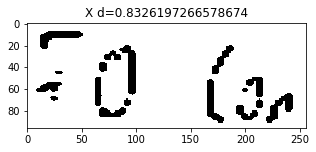

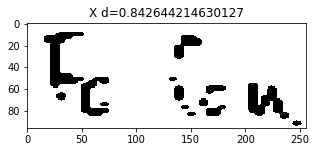

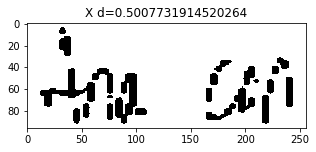

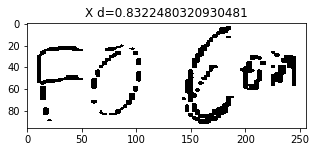

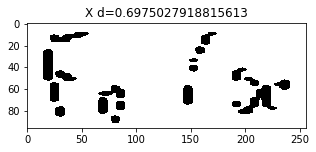

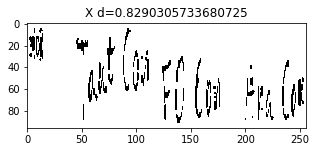

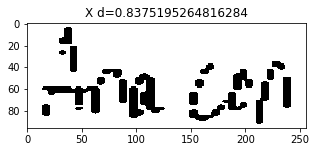

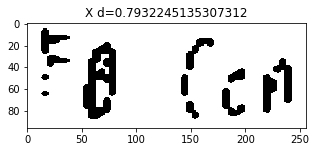

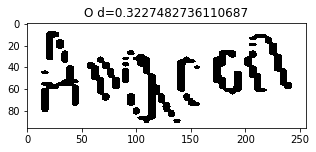

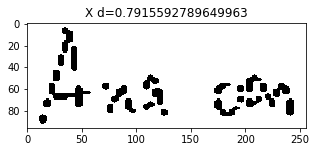

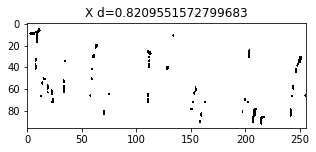

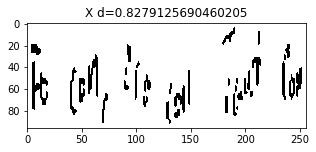

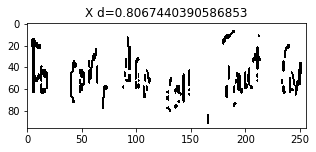

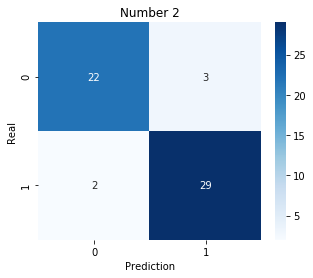

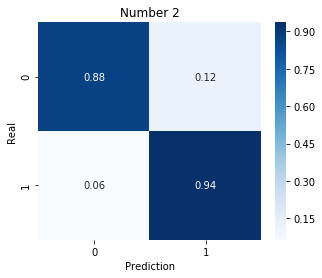

In [8]:
# test set의 이미지들을 그대로 모델에 입력값으로 주어 라벨(맞았는지 틀렸는지)과 정확도 체크
threshold = 0.5
total = 0
acc = 0
y_true = []
y_pred = []
with tf.Graph().as_default():
    sess = tf.Session()
    print("Session start")
    checkpoint_dir = "./ckpt"
    checkpoint_prefix = os.path.join(checkpoint_dir, "model5")
    saver = tf.train.import_meta_graph(checkpoint_prefix + '.meta')
    print("Graph restore")
    saver.restore(sess, checkpoint_prefix)
    print("Parameter restore")
    graph = tf.get_default_graph()

    input_x1 = graph.get_tensor_by_name('input_x1:0')
    input_x2 = graph.get_tensor_by_name('input_x2:0')
    input_batchsize = graph.get_tensor_by_name("input_batchsize:0")
    dropout = graph.get_tensor_by_name("dropout_keep_prob:0")
    output = graph.get_tensor_by_name("output/distance:0")

    
    for test_data in images_test_o:
        dists = []
        dists_2 = []
        y_true.append(1.0)
        for train_data in images_o: # 정답 첫번째 유형 집합
            x1 = train_data # 기존에 저장된 이미지들(비교를 위해)
            x2 = test_data # 새로운 이미지(맞았는지 틀렸는지 체크할 이미지)
            distance = sess.run(output,feed_dict={input_x1:[x1], input_x2:[x2], input_batchsize:1, dropout:1.0})
            dists.append(distance)
        for train_data in images_o_2: # 정답 두번째 유형 집합
            x1 = train_data
            x2 = test_data
            distance = sess.run(output,feed_dict={input_x1:[x1], input_x2:[x2], input_batchsize:1, dropout:1.0})
            dists_2.append(distance)
            
        if np.mean(dists) <= threshold or np.mean(dists_2) <= threshold: #cnt_o >= cnt_x:
            total += 1
            acc += 1
            y_pred.append(1.0)
            plt.figure(figsize=(5,4))
            plt.title("O d={}".format(min(np.mean(dists),np.mean(dists_2))))
            plt.imshow(test_data,cmap="gray")
        else:
            total += 1
            y_pred.append(0.0)
            plt.figure(figsize=(5,4))
            plt.title("X d={}".format(min(np.mean(dists),np.mean(dists_2))))
            plt.imshow(test_data,cmap="gray")

    for test_data in images_test_x:
        dists = []
        y_true.append(0.0)
        for train_data in images_o:
            x1 = train_data
            x2 = test_data
            distance = sess.run(output,feed_dict={input_x1:[x1], input_x2:[x2], input_batchsize:1, dropout:1.0})
            dists.append(distance)
        for train_data in images_o_2:
            x1 = train_data
            x2 = test_data 
            distance = sess.run(output,feed_dict={input_x1:[x1], input_x2:[x2], input_batchsize:1, dropout:1.0})
            dists_2.append(distance)

        if np.mean(dists) <= threshold or np.mean(dists_2) <= threshold:
            total += 1
            y_pred.append(1.0)
            plt.figure(figsize=(5,4))
            plt.title("O d={}".format(min(np.mean(dists),np.mean(dists_2))))
            plt.imshow(test_data,cmap="gray")
        else:
            total += 1
            acc += 1
            y_pred.append(0.0)
            plt.figure(figsize=(5,4))
            plt.title("X d={}".format(min(np.mean(dists),np.mean(dists_2))))
            plt.imshow(test_data,cmap="gray")
    print(acc/total)
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(data=cm, annot=True, cmap="Blues", fmt='.0f')
    plt.xlabel("Prediction")
    plt.ylabel("Real")
    plt.title("Number 2")
    plt.show()
    
    cm = cm.astype('float') / cm.sum(axis=1)[:,np.newaxis]
    plt.figure(figsize=(5,4))
    sns.heatmap(data=cm, annot=True, cmap="Blues", fmt='.2f')
    plt.xlabel("Prediction")
    plt.ylabel("Real")
    plt.title("Number 2")
    plt.show()